<a href="https://colab.research.google.com/github/puneat/Audio_Sentiment/blob/master/iemocap_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import re

# first test with one file
file_path = '/gdrive/My Drive/ser_tcn/iemocap/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt'

In [6]:
useful_regex = re.compile(r'\[.+\]\n', re.IGNORECASE)

In [7]:
with open(file_path) as f:
    file_content = f.read()
    
info_lines = re.findall(useful_regex, file_content)

In [8]:
for l in info_lines[1:10]:
    print(l.strip().split('\t'))

['[6.2901 - 8.2357]', 'Ses01F_impro01_F000', 'neu', '[2.5000, 2.5000, 2.5000]']
['[10.0100 - 11.3925]', 'Ses01F_impro01_F001', 'neu', '[2.5000, 2.5000, 2.5000]']
['[14.8872 - 18.0175]', 'Ses01F_impro01_F002', 'neu', '[2.5000, 2.5000, 2.5000]']
['[19.2900 - 20.7875]', 'Ses01F_impro01_F003', 'xxx', '[2.5000, 3.0000, 3.0000]']
['[21.3257 - 24.7400]', 'Ses01F_impro01_F004', 'xxx', '[2.5000, 3.0000, 2.5000]']
['[27.4600 - 31.4900]', 'Ses01F_impro01_F005', 'neu', '[2.5000, 3.5000, 2.0000]']
['[38.9650 - 43.5900]', 'Ses01F_impro01_F006', 'fru', '[2.0000, 3.5000, 3.5000]']
['[46.5800 - 52.1900]', 'Ses01F_impro01_F007', 'fru', '[2.5000, 3.5000, 3.5000]']
['[56.1600 - 58.8225]', 'Ses01F_impro01_F008', 'fru', '[2.0000, 3.5000, 3.5000]']


In [9]:
import re
import os


info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)

start_times, end_times, wav_file_names, emotions, vals, acts, doms = [], [], [], [], [], [], []

for sess in range(1, 6):
    emo_evaluation_dir = '/gdrive/My Drive/ser_tcn/iemocap/Session{}/dialog/EmoEvaluation/'.format(sess)
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        info_lines = re.findall(info_line, content)
        for line in info_lines[1:]:  # the first line is a header
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            start_time, end_time = start_end_time[1:-1].split('-')
            val, act, dom = val_act_dom[1:-1].split(',')
            val, act, dom = float(val), float(act), float(dom)
            start_time, end_time = float(start_time), float(end_time)
            start_times.append(start_time)
            end_times.append(end_time)
            wav_file_names.append(wav_file_name)
            emotions.append(emotion)
            vals.append(val)
            acts.append(act)
            doms.append(dom)

In [10]:
import pandas as pd

df_iemocap = pd.DataFrame(columns=['start_time', 'end_time', 'wav_file', 'emotion', 'val', 'act', 'dom'])

df_iemocap['start_time'] = start_times
df_iemocap['end_time'] = end_times
df_iemocap['wav_file'] = wav_file_names
df_iemocap['emotion'] = emotions
df_iemocap['val'] = vals
df_iemocap['act'] = acts
df_iemocap['dom'] = doms

df_iemocap.tail()

,start_time,end_time,wav_file,emotion,val,act,dom
10034,164.3500,170.80,Ses05F_impro07_M032,exc,4.5,4.0,4.0
10035,171.6300,173.14,Ses05F_impro07_M033,exc,4.0,3.5,3.5
10036,173.6500,175.54,Ses05F_impro07_M034,exc,4.0,3.0,3.0
10037,175.5500,178.95,Ses05F_impro07_M035,exc,3.5,3.0,3.5
10038,179.0466,185.33,Ses05F_impro07_M036,exc,4.0,3.5,3.5


In [25]:
df_iemocap.emotion.

count     10039
unique       11
top         xxx
freq       2507
Name: emotion, dtype: object

In [26]:
df_iemocap.to_csv('/gdrive/My Drive/ser_tcn/iemocap/df_iemocap.csv', index=False)

In [2]:
!pip install soundfile

In [3]:
# Try for one file first
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle

import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [4]:
file_path = '/gdrive/My Drive/ser_tcn/iemocap/Session1/dialog/wav/Ses01F_impro01.wav'

y, sr = librosa.load(file_path, sr=16000)
y, sr

(array([ 0.42692566,  0.17858887, -0.49665833, ..., -0.11756897,
        -0.49945068, -0.29483032], dtype=float32), 16000)

In [5]:
import pandas as pd
import math

labels_df = pd.read_csv('/gdrive/My Drive/ser_tcn/iemocap/df_iemocap.csv')
iemocap_dir = '/gdrive/My Drive/ser_tcn/iemocap/'

In [6]:
sr = 44100
audio_vectors = {}
for sess in range(1,6):  # using one session due to memory constraint, can replace [5] with range(1, 6)
    audio_vectors = {}
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/gdrive/My Drive/ser_tcn/iemocap/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)
    del audio_vectors

 23%|██▎       | 7/31 [01:09<03:11,  7.98s/it]

An exception occured for Ses02F_script01_1.pk


100%|██████████| 31/31 [06:57<00:00, 13.46s/it]


In [33]:
with open('/gdrive/My Drive/ser_tcn/iemocap/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
    pickle.dump(audio_vectors, f)

In [34]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [17]:
data_dir = '/gdrive/My Drive/ser_tcn/iemocap/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_5.pkl'.format(data_dir)

In [18]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [32]:
labels_df.groupby(by=['emotion']).describe()

start_time                          ...     dom               
             count        mean         std  ...     50%    75%     max
emotion                                     ...                       
ang         1103.0  169.016056   90.369474  ...  4.0000  4.500  5.0000
dis            2.0  175.565000   61.737493  ...  1.7500  1.875  2.0000
exc         1041.0  114.658044   86.655408  ...  3.5000  4.000  5.0000
fea           40.0   32.413360   46.035463  ...  2.3333  3.000  4.0000
fru         1849.0  142.968568   90.753336  ...  3.5000  4.000  5.0000
hap          595.0  176.482732  122.585770  ...  3.0000  3.500  5.0000
neu         1708.0  126.241265   95.724199  ...  3.0000  3.000  4.5000
oth            3.0  166.336433  121.965704  ...  1.6667  2.500  3.3333
sad         1084.0  178.875312  108.554189  ...  3.0000  3.500  5.0000
sur          107.0  122.737004  115.889935  ...  2.7500  3.500  4.5000
xxx         2507.0  136.201770  100.526431  ...  3.0000  3.500  5.0000

[11 rows x 40 columns]

In [30]:
labels_df.head()

,start_time,end_time,wav_file,emotion,val,act,dom
0,3.9500,10.5900,Ses01F_impro07_F000,exc,5.0,5.0,4.5
1,11.3600,16.5575,Ses01F_impro07_F001,xxx,4.0,4.5,3.5
2,19.6100,31.6500,Ses01F_impro07_F002,exc,4.0,4.0,3.0
3,32.5200,34.9000,Ses01F_impro07_F003,exc,4.5,4.5,4.5
4,37.1625,42.4900,Ses01F_impro07_F004,exc,3.0,3.5,3.0


In [27]:
np.mean(labels_df['end_time']-labels_df['start_time'])

4.460108994919817

In [39]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

In [50]:
labels_df.shape, len(audio_vectors)

((10039, 7), 2170)

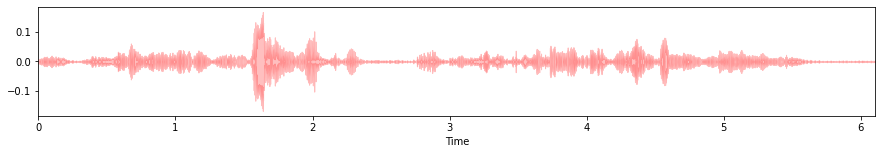

In [40]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

In [33]:
data_dir = '/gdrive/My Drive/ser_tcn/iemocap/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
labels_df = pd.read_csv(labels_df_path)

In [34]:
mfcc = np.load('/gdrive/My Drive/ser_tcn/iemocap/iemocap_mfcc.npy')

In [38]:
emotions = labels_df.emotion.values

In [43]:
np.unique(emotions, return_counts=True)

(array(['ang', 'dis', 'exc', 'fea', 'fru', 'hap', 'neu', 'oth', 'sad',
        'sur', 'xxx'], dtype=object),
 array([1103,    2, 1041,   40, 1849,  595, 1708,    3, 1084,  107, 2507]))

In [45]:
mfcc[0].shape

(128, 251, 1)

In [47]:
mfcc_less = np.empty(shape=(7380, 128, 251,1))
labels_less = []
cnt=0
labels = ['ang','exc','fru','hap','neu','sad']
for i, emo in enumerate(emotions):
    if emo in labels:
        if emo =='hap':
            mfcc_less[cnt,]=mfcc[i]
            labels_less.append(emo)
            cnt+=1
        mfcc_less[cnt,]=mfcc[i]
        labels_less.append(emo)
        cnt+=1

In [50]:
# Keras
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM, Reshape
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling2D
from keras.utils import np_utils, to_categorical,plot_model
from tensorflow.keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [52]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc_less,
                                                    labels_less,
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=labels_less)

In [53]:
del mfcc, labels_df

In [58]:
del mfcc_less, labels_less

In [55]:
# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [56]:
y_train[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [57]:
print('X train: ' + str(X_train.shape)+' X test: ' + str(X_test.shape) + ' y train: ' + str(y_train.shape) + ' y test: ' + str(y_test.shape))

X train: (5904, 128, 251, 1) X test: (1476, 128, 251, 1) y train: (5904, 6) y test: (1476, 6)


In [59]:
!pip3 install keras-tcn

     |████████████████████████████████| 378kB 3.9MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [60]:
from tcn import TCN, tcn_full_summary

In [61]:
X_train_T = np.transpose(X_train, (0, 2, 1, 3))
X_test_T = np.transpose(X_test, (0, 2, 1, 3))

In [79]:
batch_size, timesteps, input_dim = None, 251, 128
opt = optimizers.Adam(0.001, amsgrad=True)
i = Input(batch_shape=(batch_size, timesteps, input_dim, 1))

# inp = Input(shape=(timesteps, input_dim, 1))  #2D matrix of 30 MFCC bands by 216 audio length.

# X = Reshape((128000,1),name='reshape_input')(inp)
# X = LSTM(units=216,dropout=0.2,return_sequences=True,activation='relu',stateful=False,input_shape=(30,216))(X)
# X=Reshape((30,216,1),name='reshape')(X)  #2D matrix of 30 MFCC bands by 216 audio length.

x = Convolution2D(16, kernel_size=(5,5), padding="same")(i)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = AveragePooling2D(pool_size=(1,2), strides=(1,2))(x)
# x = Dropout(rate=0.3)(x)
    
x = Convolution2D(32, kernel_size=(5,5), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = AveragePooling2D(pool_size=(1,4), strides=(1,4))(x)
# x = Dropout(rate=0.3)(x)
    
x = Convolution2D(64, kernel_size=(5,5), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = AveragePooling2D(pool_size=(1,4), strides=(1,4))(x)

x = Convolution2D(128, kernel_size=(5,5), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = AveragePooling2D(pool_size=(1,4), strides=(1,4))(x)
# x = Dropout(rate=0.3)(x)
# x = GlobalAveragePooling2D()(x)    
#x = Convolution2D(256, kernel_size=(5,1), padding="same")(x)
# x = BatchNormalization()(x)
#x = Flatten()(x)
x= tf.keras.backend.squeeze(x, axis=2)
# x = Reshape((251,128))(x)
x = TCN(return_sequences=False, nb_filters=64, kernel_size=5, nb_stacks=1,
        dilations=[1,2,4,16,32]
        ,padding='same', use_skip_connections=True, dropout_rate=0.5, 
        activation='relu',use_batch_norm=True)(x)
# p = TCN(return_sequences=False,nb_filters=128, kernel_size=3, nb_stacks=5
#          ,padding='same',use_skip_connections=True,dropout_rate=0.5,
#          activation='relu',use_batch_norm=True)(o) 
#o = Dense(128, activation='relu')(o)
o = Dense(6,activation='softmax')(x)
m = Model(inputs=[i], outputs=[o])
m.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['acc'])

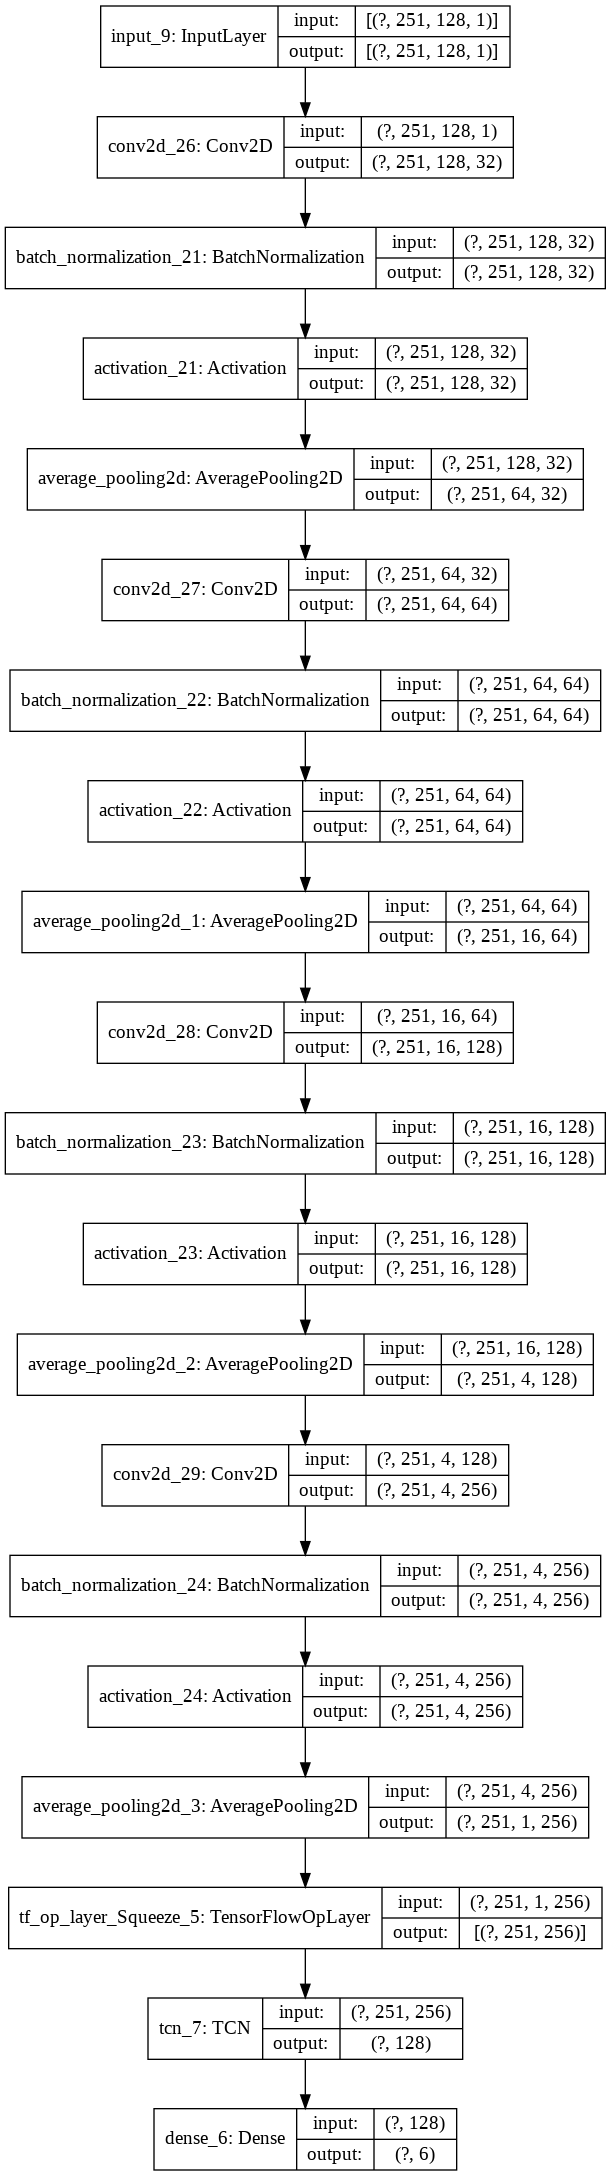

In [77]:
plot_model(m, show_shapes=True)

In [80]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model_checkpoint = ModelCheckpoint('/gdrive/My Drive/iemocap_cnn_tcn',save_best_only=True,mode='max',monitor='val_acc',verbose=2)
history=m.fit(X_train_T, 
              y_train,
              epochs=200,
              batch_size=20,
              verbose=1,
              validation_data=(X_test_T,y_test),
              shuffle=True,
              callbacks=[model_checkpoint],
              )

Epoch 1/200
296/296 [==============================] - ETA: 0s - loss: 2.8973 - acc: 0.2039
Epoch 00001: val_acc improved from -inf to 0.22561, saving model to /gdrive/My Drive/iemocap_cnn_tcn
296/296 [==============================] - 874s 3s/step - loss: 2.8973 - acc: 0.2039 - val_loss: 2.0762 - val_acc: 0.2256
Epoch 2/200
296/296 [==============================] - ETA: 0s - loss: 2.2206 - acc: 0.2038
Epoch 00002: val_acc improved from 0.22561 to 0.25068, saving model to /gdrive/My Drive/iemocap_cnn_tcn
296/296 [==============================] - 883s 3s/step - loss: 2.2206 - acc: 0.2038 - val_loss: 1.7633 - val_acc: 0.2507
Epoch 3/200
296/296 [==============================] - ETA: 0s - loss: 1.9988 - acc: 0.2122
Epoch 00003: val_acc did not improve from 0.25068
296/296 [==============================] - 871s 3s/step - loss: 1.9988 - acc: 0.2122 - val_loss: 1.7849 - val_acc: 0.2419
Epoch 4/200
 95/296 [========>.....................] - ETA: 9:09 - loss: 1.9153 - acc: 0.2347

KeyboardInterrupt: ignored